# Gut Microbiome Machine Learning Pipeline
# Part 2: Feature Engineering & Disease-Specific Classification Models


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import (StratifiedKFold, cross_validate,
                                     train_test_split)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import (roc_auc_score, roc_curve, auc, confusion_matrix,
                             classification_report, balanced_accuracy_score,
                             make_scorer)

sns.set(style="whitegrid", font_scale=1.05)
np.random.seed(2025)


# 1. Load Preprocessed Data from EDA

In [2]:
# --- MANUAL UPLOAD IN COLAB ---
from google.colab import files
import pandas as pd
import os

uploaded = files.upload()   # Upload your 3 CSVs manually

# EXPECTED FILE NAMES (must match your uploads):
#  - MetaCardis2020_relative_abundance.csv
#  - MetaCardis2020_sample_metadata.csv
#  - MetaCardis2020_taxa_metadata.csv

# Create folders for saving results
data_dir = "data"
RESULTS = os.path.join(data_dir, "results_EDA")
FIGS = os.path.join(RESULTS, "figures")
TABLES = os.path.join(RESULTS, "tables")

os.makedirs(FIGS, exist_ok=True)
os.makedirs(TABLES, exist_ok=True)

# Load all uploaded files
ab_raw = pd.read_csv("MetaCardis2020_relative_abundance.csv", index_col=0)
meta = pd.read_csv("MetaCardis2020_sample_metadata.csv", index_col=0)
taxa_meta = pd.read_csv("MetaCardis2020_taxa_metadata.csv", index_col=0)

print("Data shapes:")
print(f"  Abundance: {ab_raw.shape}")
print(f"  Metadata: {meta.shape}")
print(f"  Taxa metadata: {taxa_meta.shape}")

Saving MetaCardis2020_relative_abundance.csv to MetaCardis2020_relative_abundance.csv
Saving MetaCardis2020_sample_metadata.csv to MetaCardis2020_sample_metadata.csv
Saving MetaCardis2020_taxa_metadata.csv to MetaCardis2020_taxa_metadata.csv
Data shapes:
  Abundance: (697, 1831)
  Metadata: (1831, 25)
  Taxa metadata: (697, 7)


In [3]:
# --- MANUAL UPLOAD IN COLAB FOR PREPROCESSED FILES ---
from google.colab import files
import pandas as pd
import os

print("Upload the 4 preprocessed CSVs from your EDA step:")
uploaded = files.upload()

# REQUIRED FILES (must match upload names):
#  - abundance_clr.csv
#  - metadata_with_disease_groups.csv
#  - alpha_diversity.csv
#  - abundance_filtered_relative.csv

# Create ML result directories
RESULTS = "results_EDA"
ML_FIGS = os.path.join(RESULTS, "ml_figures")
ML_TABLES = os.path.join(RESULTS, "ml_tables")
os.makedirs(ML_FIGS, exist_ok=True)
os.makedirs(ML_TABLES, exist_ok=True)

# Load preprocessed data
ab_clr = pd.read_csv("abundance_clr.csv", index_col=0)
meta = pd.read_csv("metadata_with_disease_groups.csv", index_col=0)
alpha = pd.read_csv("alpha_diversity.csv", index_col=0)
ab_rel = pd.read_csv("abundance_filtered_relative.csv", index_col=0)

print("\nLoaded data:")
print(f"  CLR-transformed abundances: {ab_clr.shape}")
print(f"  Metadata: {meta.shape}")
print(f"  Alpha diversity: {alpha.shape}")
print(f"  Relative abundances: {ab_rel.shape}")

# Align all datasets by common sample IDs
common_idx = ab_clr.index.intersection(meta.index).intersection(alpha.index)

ab_clr = ab_clr.loc[common_idx]
ab_rel = ab_rel.loc[common_idx]
meta = meta.loc[common_idx]
alpha = alpha.loc[common_idx]

print(f"\nAfter alignment: {len(common_idx)} samples")


Upload the 4 preprocessed CSVs from your EDA step:


Saving abundance_clr.csv to abundance_clr.csv
Saving abundance_filtered_relative.csv to abundance_filtered_relative.csv
Saving alpha_diversity.csv to alpha_diversity.csv
Saving metadata_with_disease_groups.csv to metadata_with_disease_groups.csv

Loaded data:
  CLR-transformed abundances: (1831, 362)
  Metadata: (1831, 28)
  Alpha diversity: (1831, 6)
  Relative abundances: (1831, 362)

After alignment: 1831 samples


# 2. Feature Engineering

In [4]:
def engineer_ratio_features(ab_rel, top_n=50):
    """
    Create ratio features between abundant taxa.
    These can capture ecological relationships.
    """
    print("\nEngineering ratio features...")

    # Select top N most abundant taxa
    mean_abundance = ab_rel.mean(axis=0).sort_values(ascending=False)
    top_taxa = mean_abundance.head(top_n).index

    ratio_features = pd.DataFrame(index=ab_rel.index)

    # Create key ratios (Firmicutes/Bacteroidetes, etc.)
    # This is a simplified example - you could create more domain-specific ratios
    for i, taxon1 in enumerate(top_taxa[:10]):
        for taxon2 in top_taxa[i+1:15]:
            ratio_name = f"ratio_{taxon1[:20]}_{taxon2[:20]}"
            ratio_features[ratio_name] = np.log10(
                (ab_rel[taxon1] + 1e-6) / (ab_rel[taxon2] + 1e-6)
            )

    print(f"  Created {ratio_features.shape[1]} ratio features")
    return ratio_features


In [5]:
def engineer_clinical_features(meta):
    """
    Extract and engineer features from clinical metadata.
    """
    print("\nEngineering clinical features...")

    clinical_features = pd.DataFrame(index=meta.index)
    n_features = 0

    # 1. BMI features
    if 'BMI' in meta.columns:
        clinical_features['BMI'] = meta['BMI'].astype(float)
        clinical_features['is_obese'] = (meta['BMI'] >= 30).astype(float)
        clinical_features['is_overweight'] = ((meta['BMI'] >= 25) & (meta['BMI'] < 30)).astype(float)
        n_features += 3
        print(f"  ✓ BMI features: {meta['BMI'].notna().sum()} samples with data")

    # 2. Age categories
    if 'age_category' in meta.columns:
        age_dummies = pd.get_dummies(meta['age_category'], prefix='age', drop_first=True)
        clinical_features = pd.concat([clinical_features, age_dummies], axis=1)
        n_features += age_dummies.shape[1]
        print(f"  ✓ Age categories: {age_dummies.shape[1]} features")

    # 3. Gender
    if 'gender' in meta.columns:
        clinical_features['is_male'] = (meta['gender'].str.lower() == 'male').astype(float)
        n_features += 1
        print(f"  ✓ Gender: {clinical_features['is_male'].notna().sum()} samples")

    # 4. Metabolic markers (z-scored)
    metabolic_markers = ['triglycerides', 'hba1c', 'LDL', 'HDL', 'hsCRP']
    for marker in metabolic_markers:
        if marker in meta.columns:
            values = meta[marker].astype(float)
            if values.notna().sum() > 10:  # Only if enough data
                mean = values.mean()
                std = values.std()
                if std > 0:
                    clinical_features[f'{marker}_zscore'] = (values - mean) / std
                    n_features += 1
                    print(f"  ✓ {marker}: {values.notna().sum()} samples")

    # 5. Smoking status
    if 'smoke' in meta.columns:
        clinical_features['is_smoker'] = meta['smoke'].notna().astype(float)
        n_features += 1

    # 6. Antibiotic use
    if 'antibiotic_use' in meta.columns:
        clinical_features['antibiotic_yes'] = (meta['antibiotic_use'] == 'yes').astype(float)
        clinical_features['antibiotic_unknown'] = (meta['antibiotic_use'] == 'unknown').astype(float)
        n_features += 2
        print(f"  ✓ Antibiotics: yes={clinical_features['antibiotic_yes'].sum()}, "
              f"unknown={clinical_features['antibiotic_unknown'].sum()}")

    # 7. Country/Region (if available)
    if 'country' in meta.columns:
        country_counts = meta['country'].value_counts()
        common_countries = country_counts[country_counts > 50].index
        if len(common_countries) > 1:
            meta['country_grouped'] = meta['country'].apply(
                lambda x: x if x in common_countries else 'other'
            )
            country_dummies = pd.get_dummies(meta['country_grouped'], prefix='country', drop_first=True)
            clinical_features = pd.concat([clinical_features, country_dummies], axis=1)
            n_features += country_dummies.shape[1]
            print(f"  ✓ Country: {country_dummies.shape[1]} features")

    print(f"\nTotal clinical features: {n_features}")

    return clinical_features


In [6]:
def combine_feature_sets(ab_clr, alpha, clinical_features=None, ratio_features=None):
    """
    Combine different feature sets into a single matrix.
    """
    print("\nCombining feature sets...")

    feature_sets = [ab_clr]
    feature_names = ['microbiome_clr']

    # Add alpha diversity
    if alpha is not None:
        alpha_subset = alpha[['richness', 'shannon', 'simpson']]
        feature_sets.append(alpha_subset)
        feature_names.append('alpha_diversity')

    # Add ratio features
    if ratio_features is not None:
        feature_sets.append(ratio_features)
        feature_names.append('ratio_features')

    # Add clinical features
    if clinical_features is not None:
        feature_sets.append(clinical_features)
        feature_names.append('clinical')

    # Combine
    X_combined = pd.concat(feature_sets, axis=1)

    # Handle missing values
    # Binary features: fill with 0
    # Continuous: fill with median
    for col in X_combined.columns:
        if X_combined[col].isna().any():
            if X_combined[col].nunique() <= 2:
                X_combined[col] = X_combined[col].fillna(0)
            else:
                X_combined[col] = X_combined[col].fillna(X_combined[col].median())

    print(f"\nCombined feature matrix: {X_combined.shape}")
    print(f"Feature sets included: {', '.join(feature_names)}")
    print(f"Missing values remaining: {X_combined.isna().sum().sum()}")

    return X_combined


In [7]:
# Create feature sets
ratio_features = engineer_ratio_features(ab_rel, top_n=50)
clinical_features = engineer_clinical_features(meta)

# Combine all features
X_full = combine_feature_sets(ab_clr, alpha, clinical_features, ratio_features)

# Also create microbiome-only version for comparison
X_microbiome = ab_clr.copy()

print(f"\nFeature matrices created:")
print(f"  Microbiome-only: {X_microbiome.shape}")
print(f"  Full (microbiome + clinical + ratios): {X_full.shape}")



Engineering ratio features...
  Created 95 ratio features

Engineering clinical features...
  ✓ BMI features: 1310 samples with data
  ✓ Age categories: 1 features
  ✓ Gender: 1831 samples
  ✓ triglycerides: 844 samples
  ✓ hba1c: 839 samples
  ✓ LDL: 841 samples
  ✓ hsCRP: 829 samples
  ✓ Antibiotics: yes=783.0, unknown=104.0
  ✓ Country: 2 features

Total clinical features: 14

Combining feature sets...

Combined feature matrix: (1831, 474)
Feature sets included: microbiome_clr, alpha_diversity, ratio_features, clinical
Missing values remaining: 0

Feature matrices created:
  Microbiome-only: (1831, 362)
  Full (microbiome + clinical + ratios): (1831, 474)


In [47]:
# Create feature sets
ratio_features = engineer_ratio_features(ab_rel, top_n=50)
clinical_features = engineer_clinical_features(meta)

# Combine all features
X_full = combine_feature_sets(ab_clr, alpha, clinical_features, ratio_features)

# Convert boolean columns to float64
bool_cols = X_full.select_dtypes(include=['bool']).columns
if len(bool_cols) > 0:
    print(f"\nConverting {len(bool_cols)} boolean columns to float64: {bool_cols.tolist()}")
    X_full[bool_cols] = X_full[bool_cols].astype(np.float64)

# Verify all columns are numeric
print(f"\nX_full dtypes after conversion:")
print(X_full.dtypes.value_counts())
# ============================

# Also create microbiome-only version for comparison
X_microbiome = ab_clr.copy()


Engineering ratio features...
  Created 95 ratio features

Engineering clinical features...
  ✓ BMI features: 1310 samples with data
  ✓ Age categories: 1 features
  ✓ Gender: 1831 samples
  ✓ triglycerides: 844 samples
  ✓ hba1c: 839 samples
  ✓ LDL: 841 samples
  ✓ hsCRP: 829 samples
  ✓ Antibiotics: yes=783.0, unknown=104.0
  ✓ Country: 2 features

Total clinical features: 14

Combining feature sets...

Combined feature matrix: (1831, 474)
Feature sets included: microbiome_clr, alpha_diversity, ratio_features, clinical
Missing values remaining: 0

Converting 3 boolean columns to float64: ['age_senior', 'country_DNK', 'country_FRA']

X_full dtypes after conversion:
float64    473
int64        1
Name: count, dtype: int64


# 3. Disease-Specific Classification Models

In [48]:
def train_disease_specific_model(X, meta, disease_group, model_type='logistic',
                                  n_cv_folds=5, feature_selection=None, n_features=100):
    """
    Train a classification model for a specific disease group vs. controls.

    Parameters:
    -----------
    X : DataFrame - Feature matrix
    meta : DataFrame - Metadata with disease_group column
    disease_group : str - Disease group to model ('metabolic' or 'cardiovascular')
    model_type : str - 'logistic' or 'random_forest'
    n_cv_folds : int - Number of cross-validation folds
    feature_selection : str - 'univariate', 'mutual_info', or None
    n_features : int - Number of features to select (if feature_selection is not None)
    """
    print(f"\n{'='*70}")
    print(f"TRAINING MODEL: {disease_group.upper()} vs CONTROL")
    print('='*70)

    # Select samples: disease group + controls
    control_idx = meta['disease_group'] == 'control'
    disease_idx = meta['disease_group'] == disease_group
    selected_idx = control_idx | disease_idx

    X_subset = X.loc[selected_idx]
    y_subset = disease_idx[selected_idx].astype(int).values

    n_disease = y_subset.sum()
    n_control = (y_subset == 0).sum()

    print(f"\nDataset:")
    print(f"  Controls: {n_control}")
    print(f"  {disease_group.capitalize()}: {n_disease}")
    print(f"  Features: {X_subset.shape[1]}")
    print(f"  Class balance: {n_disease / (n_disease + n_control):.2%} disease")

    # Feature selection
    if feature_selection == 'univariate':
        print(f"\nPerforming univariate feature selection (top {n_features})...")
        selector = SelectKBest(f_classif, k=min(n_features, X_subset.shape[1]))
        X_subset_transformed = selector.fit_transform(X_subset.values, y_subset)
        selected_features = X_subset.columns[selector.get_support()].tolist()
        print(f"  Selected {len(selected_features)} features")
        X_subset = pd.DataFrame(X_subset_transformed,
                               index=X_subset.index,
                               columns=selected_features)

    # Initialize model
    if model_type == 'logistic':
        model = LogisticRegressionCV(
            cv=5,
            penalty='l2',
            max_iter=1000,
            class_weight='balanced',
            random_state=2025,
            n_jobs=-1,
            scoring='roc_auc'
        )
        print(f"\nModel: Logistic Regression with L2 regularization")
    elif model_type == 'random_forest':
        model = RandomForestClassifier(
            n_estimators=200,
            max_depth=10,
            min_samples_split=20,
            min_samples_leaf=10,
            class_weight='balanced',
            random_state=2025,
            n_jobs=-1
        )
        print(f"\nModel: Random Forest")

    # Cross-validation evaluation
    cv = StratifiedKFold(n_splits=n_cv_folds, shuffle=True, random_state=2025)

    scoring = {
        'roc_auc': 'roc_auc',
        'accuracy': 'accuracy',
        'balanced_acc': make_scorer(balanced_accuracy_score),
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1'
    }

    print(f"\nPerforming {n_cv_folds}-fold cross-validation...")
    cv_results = cross_validate(
        model, X_subset.values, y_subset,
        cv=cv,
        scoring=scoring,
        return_train_score=True,
        n_jobs=-1
    )

    # Print results
    print(f"\nCross-Validation Results:")
    print(f"{'Metric':<15} {'Train':<20} {'Test':<20}")
    print('-'*55)

    results_dict = {}
    for metric in scoring.keys():
        train_mean = cv_results[f'train_{metric}'].mean()
        train_std = cv_results[f'train_{metric}'].std()
        test_mean = cv_results[f'test_{metric}'].mean()
        test_std = cv_results[f'test_{metric}'].std()

        results_dict[metric] = {
            'train_mean': train_mean,
            'train_std': train_std,
            'test_mean': test_mean,
            'test_std': test_std
        }

        print(f"{metric:<15} {train_mean:.3f} ± {train_std:.3f}      "
              f"{test_mean:.3f} ± {test_std:.3f}")

    # Check for overfitting
    auc_gap = results_dict['roc_auc']['train_mean'] - results_dict['roc_auc']['test_mean']
    if auc_gap > 0.1:
        print(f"\nWarning: Possible overfitting (train-test AUC gap: {auc_gap:.3f})")

    # Fit model on full dataset for feature importance
    model.fit(X_subset.values, y_subset)

    # Extract feature importance
    feature_importance = None
    if model_type == 'logistic':
        coefs = model.coef_[0]
        feature_importance = pd.DataFrame({
            'feature': X_subset.columns,
            'coefficient': coefs,
            'abs_coefficient': np.abs(coefs)
        }).sort_values('abs_coefficient', ascending=False)

        print(f"\nTop 15 Features (Logistic Regression Coefficients):")
        print(f"{'Feature':<50} {'Coefficient':>12} {'Direction'}")
        print('-'*70)
        for _, row in feature_importance.head(15).iterrows():
            direction = '↑ Disease' if row['coefficient'] > 0 else '↓ Disease'
            feat_name = row['feature'][:47] + '...' if len(row['feature']) > 50 else row['feature']
            print(f"{feat_name:<50} {row['coefficient']:>12.4f}  {direction}")

    elif model_type == 'random_forest':
        importances = model.feature_importances_
        feature_importance = pd.DataFrame({
            'feature': X_subset.columns,
            'importance': importances
        }).sort_values('importance', ascending=False)

        print(f"\nTop 15 Features (Random Forest Importance):")
        print(f"{'Feature':<50} {'Importance':>12}")
        print('-'*70)
        for _, row in feature_importance.head(15).iterrows():
            feat_name = row['feature'][:47] + '...' if len(row['feature']) > 50 else row['feature']
            print(f"{feat_name:<50} {row['importance']:>12.4f}")

    return {
        'model': model,
        'cv_results': results_dict,
        'feature_importance': feature_importance,
        'X_train': X_subset,
        'y_train': y_subset,
        'n_control': n_control,
        'n_disease': n_disease
    }


# 5. Model Comparison Visualization

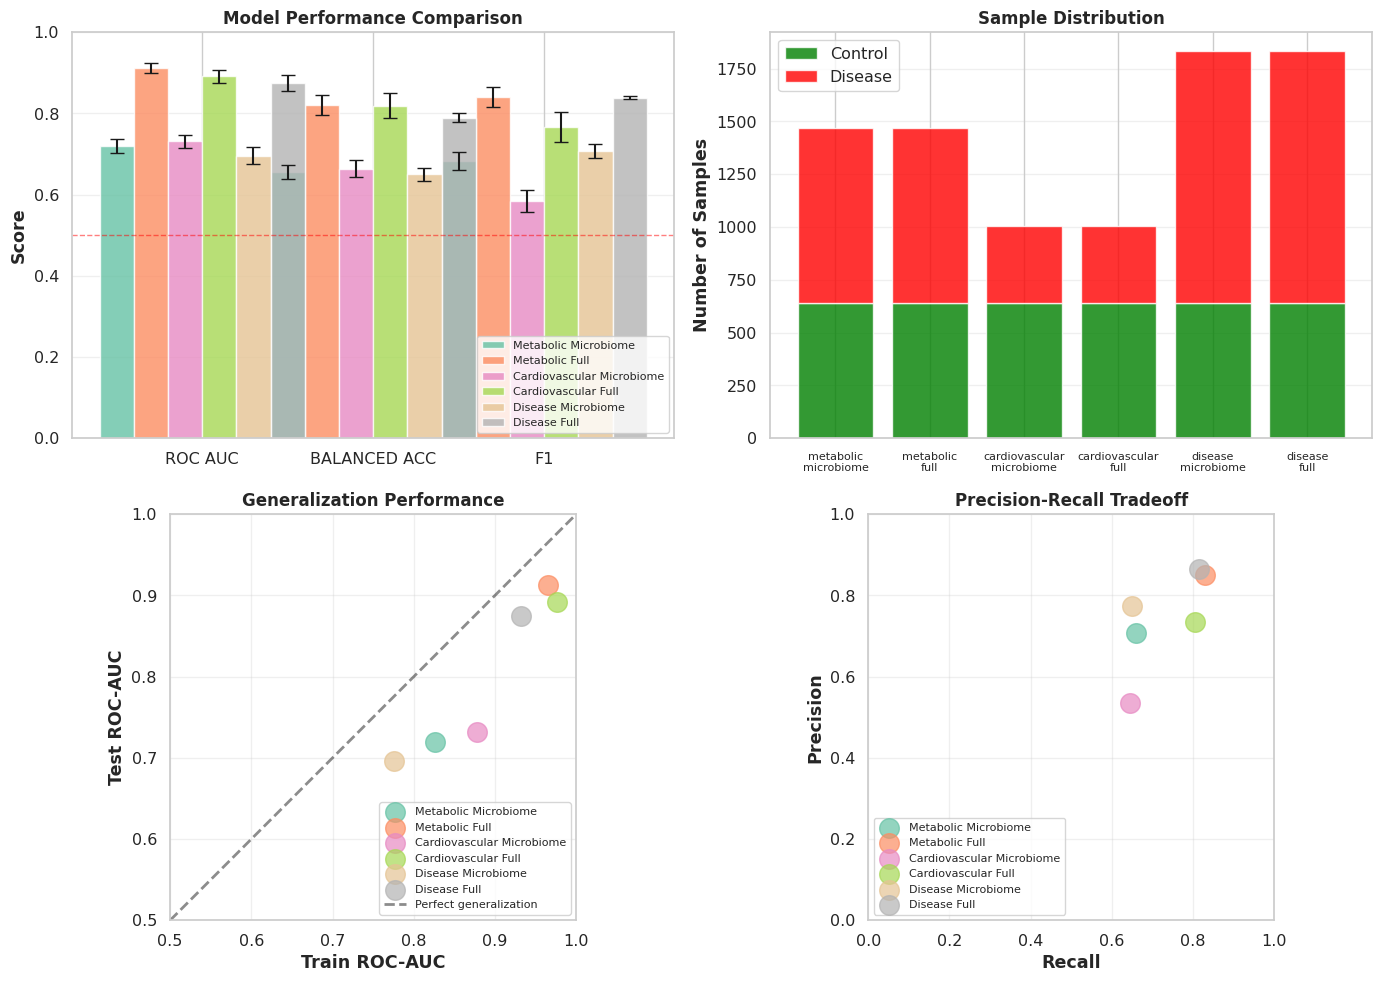

In [49]:
def plot_model_comparison(results_dict):
    """
    Create comprehensive comparison plots for all models.
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    models = list(results_dict.keys())
    metrics = ['roc_auc', 'balanced_acc', 'f1']
    colors = plt.cm.Set2(np.linspace(0, 1, len(models)))

    # 1. Performance metrics comparison
    ax = axes[0, 0]
    x = np.arange(len(metrics))
    width = 0.2

    for i, (model_name, color) in enumerate(zip(models, colors)):
        values = [results_dict[model_name]['cv_results'][m]['test_mean'] for m in metrics]
        errors = [results_dict[model_name]['cv_results'][m]['test_std'] for m in metrics]

        ax.bar(x + i*width, values, width, yerr=errors,
               label=model_name.replace('_', ' ').title(),
               alpha=0.8, capsize=5, color=color)

    ax.set_ylabel('Score', fontweight='bold')
    ax.set_title('Model Performance Comparison', fontweight='bold', fontsize=12)
    ax.set_xticks(x + width * (len(models)-1) / 2)
    ax.set_xticklabels([m.upper().replace('_', ' ') for m in metrics])
    ax.legend(loc='lower right', fontsize=8)
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 1.0])
    ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, linewidth=1)

    # 2. Sample sizes
    ax = axes[0, 1]
    sample_data = []
    for model_name in models:
        sample_data.append({
            'model': model_name.replace('_', '\n'),
            'control': results_dict[model_name]['n_control'],
            'disease': results_dict[model_name]['n_disease']
        })

    df_samples = pd.DataFrame(sample_data)
    x_pos = np.arange(len(df_samples))

    ax.bar(x_pos, df_samples['control'], label='Control', alpha=0.8, color='green')
    ax.bar(x_pos, df_samples['disease'], bottom=df_samples['control'],
           label='Disease', alpha=0.8, color='red')

    ax.set_ylabel('Number of Samples', fontweight='bold')
    ax.set_title('Sample Distribution', fontweight='bold', fontsize=12)
    ax.set_xticks(x_pos)
    ax.set_xticklabels([m.replace('_', '\n') for m in models], fontsize=8)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

    # 3. Train vs Test AUC (overfitting check)
    ax = axes[1, 0]

    for i, (model_name, color) in enumerate(zip(models, colors)):
        train_auc = results_dict[model_name]['cv_results']['roc_auc']['train_mean']
        test_auc = results_dict[model_name]['cv_results']['roc_auc']['test_mean']

        ax.scatter(train_auc, test_auc, s=200, alpha=0.7, color=color,
                  label=model_name.replace('_', ' ').title())

    # Diagonal line (perfect generalization)
    lim = [0.5, 1.0]
    ax.plot(lim, lim, 'k--', alpha=0.5, linewidth=2, label='Perfect generalization')

    ax.set_xlabel('Train ROC-AUC', fontweight='bold')
    ax.set_ylabel('Test ROC-AUC', fontweight='bold')
    ax.set_title('Generalization Performance', fontweight='bold', fontsize=12)
    ax.legend(fontsize=8, loc='lower right')
    ax.grid(alpha=0.3)
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    ax.set_aspect('equal')

    # 4. Precision-Recall tradeoff
    ax = axes[1, 1]

    for i, (model_name, color) in enumerate(zip(models, colors)):
        precision = results_dict[model_name]['cv_results']['precision']['test_mean']
        recall = results_dict[model_name]['cv_results']['recall']['test_mean']

        ax.scatter(recall, precision, s=200, alpha=0.7, color=color,
                  label=model_name.replace('_', ' ').title())

    ax.set_xlabel('Recall', fontweight='bold')
    ax.set_ylabel('Precision', fontweight='bold')
    ax.set_title('Precision-Recall Tradeoff', fontweight='bold', fontsize=12)
    ax.legend(fontsize=8, loc='lower left')
    ax.grid(alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_aspect('equal')

    plt.tight_layout()
    plt.savefig(os.path.join(ML_FIGS, 'model_comparison_comprehensive.png'),
                dpi=300, bbox_inches='tight')
    plt.show()

plot_model_comparison(results)


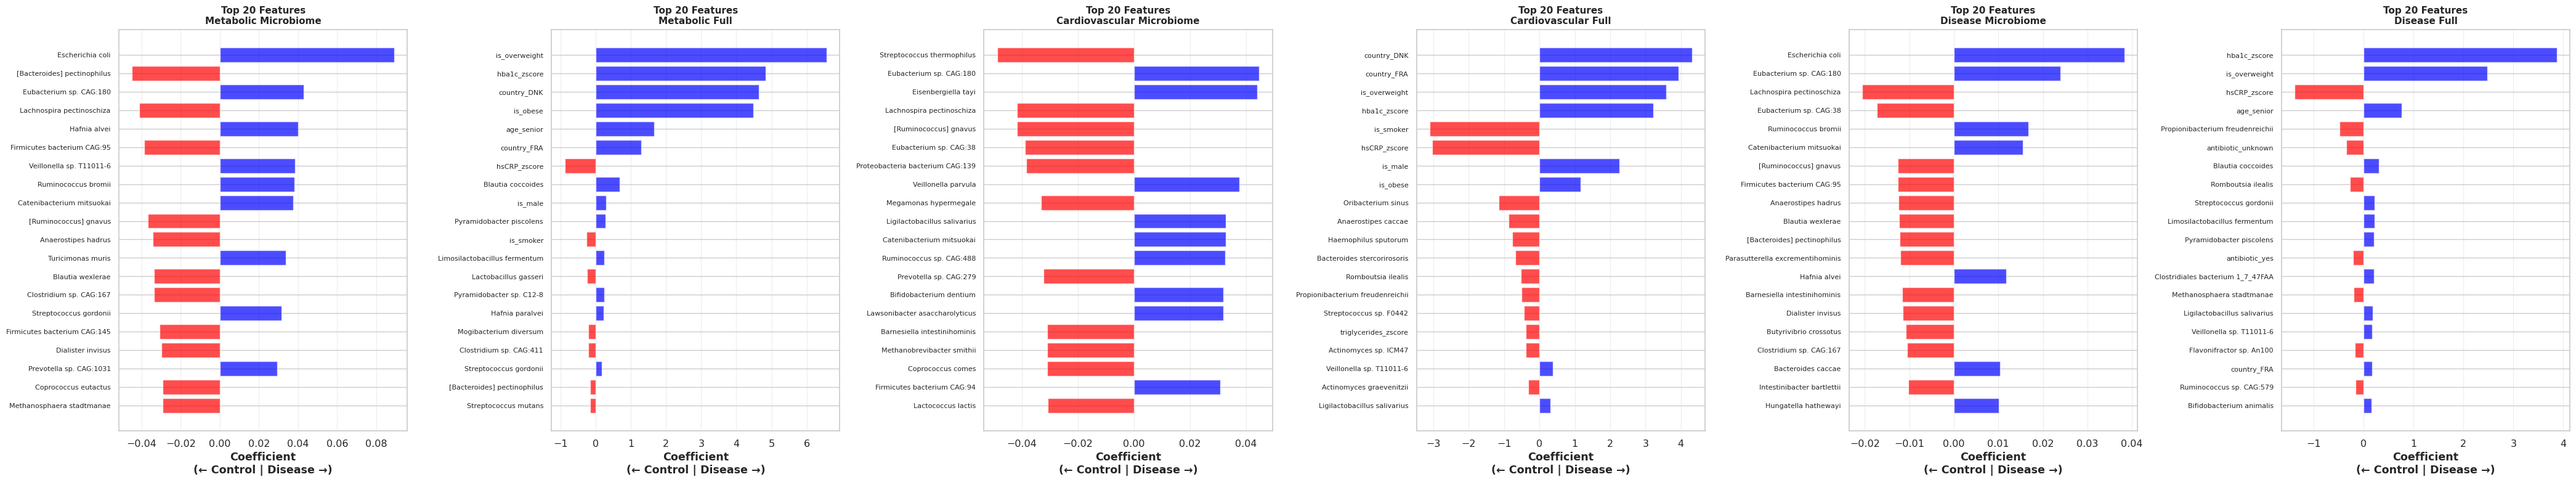

In [50]:
def plot_feature_importance_comparison(results_dict):
    """
    Plot top features for each model side-by-side.
    """
    n_models = len(results_dict)
    fig, axes = plt.subplots(1, n_models, figsize=(7*n_models, 8))

    if n_models == 1:
        axes = [axes]

    for ax, (model_name, result) in zip(axes, results_dict.items()):
        fi = result['feature_importance']
        if fi is None:
            continue

        top_features = fi.head(20)

        if 'coefficient' in fi.columns:
            # Logistic regression
            colors = ['red' if x < 0 else 'blue' for x in top_features['coefficient']]
            y_pos = np.arange(len(top_features))
            ax.barh(y_pos, top_features['coefficient'], color=colors, alpha=0.7)
            ax.set_xlabel('Coefficient\n(← Control | Disease →)', fontweight='bold')
        else:
            # Random forest
            y_pos = np.arange(len(top_features))
            ax.barh(y_pos, top_features['importance'], color='steelblue', alpha=0.7)
            ax.set_xlabel('Feature Importance', fontweight='bold')

        # Shorten feature names for display
        feature_labels = [f[:40] + '...' if len(f) > 40 else f
                         for f in top_features['feature']]
        ax.set_yticks(y_pos)
        ax.set_yticklabels(feature_labels, fontsize=8)
        ax.invert_yaxis()
        ax.set_title(f'Top 20 Features\n{model_name.replace("_", " ").title()}',
                    fontweight='bold', fontsize=11)
        ax.grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(ML_FIGS, 'feature_importance_comparison.png'),
                dpi=300, bbox_inches='tight')
    plt.show()

plot_feature_importance_comparison(results)


# 6. Save Results

In [51]:
print("SAVING RESULTS")

# Create summary table
summary_data = []
for model_name, result in results.items():
    cv = result['cv_results']
    summary_data.append({
        'Model': model_name,
        'Disease_Group': 'metabolic' if 'metabolic' in model_name else 'cardiovascular',
        'Feature_Set': 'microbiome_only' if 'microbiome' in model_name else 'full',
        'N_Controls': result['n_control'],
        'N_Disease': result['n_disease'],
        'ROC_AUC_mean': cv['roc_auc']['test_mean'],
        'ROC_AUC_std': cv['roc_auc']['test_std'],
        'Balanced_Acc_mean': cv['balanced_acc']['test_mean'],
        'Balanced_Acc_std': cv['balanced_acc']['test_std'],
        'Precision_mean': cv['precision']['test_mean'],
        'Recall_mean': cv['recall']['test_mean'],
        'F1_mean': cv['f1']['test_mean']
    })

summary_df = pd.DataFrame(summary_data)
summary_df.to_csv(os.path.join(ML_TABLES, 'model_performance_summary.csv'), index=False)

print("\nModel Performance Summary:")
print(summary_df.to_string(index=False))


SAVING RESULTS

Model Performance Summary:
                    Model  Disease_Group     Feature_Set  N_Controls  N_Disease  ROC_AUC_mean  ROC_AUC_std  Balanced_Acc_mean  Balanced_Acc_std  Precision_mean  Recall_mean  F1_mean
     metabolic_microbiome      metabolic microbiome_only         642        825      0.719689     0.017986           0.655085          0.017870        0.707627     0.660606 0.683075
           metabolic_full      metabolic            full         642        825      0.912319     0.012882           0.821668          0.024560        0.850981     0.830303 0.840208
cardiovascular_microbiome cardiovascular microbiome_only         642        364      0.731378     0.016338           0.663970          0.020680        0.535711     0.645624 0.584808
      cardiovascular_full cardiovascular            full         642        364      0.891492     0.016176           0.819022          0.031511        0.734384     0.804795 0.766182
       disease_microbiome cardiovascular microb

In [52]:
# Save feature importance for each model
for model_name, result in results.items():
    if result['feature_importance'] is not None:
        filename = f'feature_importance_{model_name}.csv'
        result['feature_importance'].to_csv(
            os.path.join(ML_TABLES, filename),
            index=False
        )
        print(f"  Saved: {filename}")


  Saved: feature_importance_metabolic_microbiome.csv
  Saved: feature_importance_metabolic_full.csv
  Saved: feature_importance_cardiovascular_microbiome.csv
  Saved: feature_importance_cardiovascular_full.csv
  Saved: feature_importance_disease_microbiome.csv
  Saved: feature_importance_disease_full.csv


In [53]:
# Save detailed CV results
cv_detailed = []
for model_name, result in results.items():
    for metric, values in result['cv_results'].items():
        cv_detailed.append({
            'Model': model_name,
            'Metric': metric,
            'Train_Mean': values['train_mean'],
            'Train_Std': values['train_std'],
            'Test_Mean': values['test_mean'],
            'Test_Std': values['test_std']
        })

cv_detailed_df = pd.DataFrame(cv_detailed)
cv_detailed_df.to_csv(os.path.join(ML_TABLES, 'cv_results_detailed.csv'), index=False)


In [54]:
# All Diseases (Metabolic + Cardiovascular) vs Controls
print("ALL DISEASES (COMBINED)")

# First, create a combined disease group in metadata if not already present
meta['disease_combined'] = meta['disease_group'].apply(
    lambda x: 'disease' if x in ['metabolic', 'cardiovascular'] else x
)

print(f"\nCombined disease group distribution:")
print(meta['disease_combined'].value_counts())


ALL DISEASES (COMBINED)

Combined disease group distribution:
disease_combined
disease    1189
control     642
Name: count, dtype: int64


In [55]:
# Train models with combined disease group
# We need to modify the function call slightly to use the combined disease column

def train_combined_disease_model(X, meta, model_type='logistic',
                                  n_cv_folds=5, feature_selection=None, n_features=100):
    """
    Train a classification model for ALL diseases vs. controls.
    """
    print(f"TRAINING MODEL: ALL DISEASES vs CONTROL")

    # Select samples: all diseases + controls
    control_idx = meta['disease_combined'] == 'control'
    disease_idx = meta['disease_combined'] == 'disease'
    selected_idx = control_idx | disease_idx

    X_subset = X.loc[selected_idx]
    y_subset = disease_idx[selected_idx].astype(int).values

    n_disease = y_subset.sum()
    n_control = (y_subset == 0).sum()

    print(f"\nDataset:")
    print(f"  Controls: {n_control}")
    print(f"  All Diseases: {n_disease}")
    print(f"  Features: {X_subset.shape[1]}")
    print(f"  Class balance: {n_disease / (n_disease + n_control):.2%} disease")

    # Feature selection
    if feature_selection == 'univariate':
        print(f"\nPerforming univariate feature selection (top {n_features})...")
        selector = SelectKBest(f_classif, k=min(n_features, X_subset.shape[1]))
        X_subset_transformed = selector.fit_transform(X_subset.values, y_subset)
        selected_features = X_subset.columns[selector.get_support()].tolist()
        print(f"  Selected {len(selected_features)} features")
        X_subset = pd.DataFrame(X_subset_transformed,
                               index=X_subset.index,
                               columns=selected_features)

    # Initialize model
    if model_type == 'logistic':
        model = LogisticRegressionCV(
            cv=5,
            penalty='l2',
            max_iter=1000,
            class_weight='balanced',
            random_state=2025,
            n_jobs=-1,
            scoring='roc_auc'
        )
        print(f"\nModel: Logistic Regression with L2 regularization")
    elif model_type == 'random_forest':
        model = RandomForestClassifier(
            n_estimators=200,
            max_depth=10,
            min_samples_split=20,
            min_samples_leaf=10,
            class_weight='balanced',
            random_state=2025,
            n_jobs=-1
        )
        print(f"\nModel: Random Forest")

    # Cross-validation evaluation
    cv = StratifiedKFold(n_splits=n_cv_folds, shuffle=True, random_state=2025)

    scoring = {
        'roc_auc': 'roc_auc',
        'accuracy': 'accuracy',
        'balanced_acc': make_scorer(balanced_accuracy_score),
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1'
    }

    print(f"\nPerforming {n_cv_folds}-fold cross-validation...")
    cv_results = cross_validate(
        model, X_subset.values, y_subset,
        cv=cv,
        scoring=scoring,
        return_train_score=True,
        n_jobs=-1
    )

    # Print results
    print(f"\nCross-Validation Results:")
    print(f"{'Metric':<15} {'Train':<20} {'Test':<20}")
    print('-'*55)

    results_dict = {}
    for metric in scoring.keys():
        train_mean = cv_results[f'train_{metric}'].mean()
        train_std = cv_results[f'train_{metric}'].std()
        test_mean = cv_results[f'test_{metric}'].mean()
        test_std = cv_results[f'test_{metric}'].std()

        results_dict[metric] = {
            'train_mean': train_mean,
            'train_std': train_std,
            'test_mean': test_mean,
            'test_std': test_std
        }

        print(f"{metric:<15} {train_mean:.3f} ± {train_std:.3f}      "
              f"{test_mean:.3f} ± {test_std:.3f}")

    # Check for overfitting
    auc_gap = results_dict['roc_auc']['train_mean'] - results_dict['roc_auc']['test_mean']
    if auc_gap > 0.1:
        print(f"\nWarning: Possible overfitting (train-test AUC gap: {auc_gap:.3f})")

    # Fit model on full dataset for feature importance
    model.fit(X_subset.values, y_subset)

    # Extract feature importance
    feature_importance = None
    if model_type == 'logistic':
        coefs = model.coef_[0]
        feature_importance = pd.DataFrame({
            'feature': X_subset.columns,
            'coefficient': coefs,
            'abs_coefficient': np.abs(coefs)
        }).sort_values('abs_coefficient', ascending=False)

        print(f"\nTop 15 Features (Logistic Regression Coefficients):")
        print(f"{'Feature':<50} {'Coefficient':>12} {'Direction'}")
        print('-'*70)
        for _, row in feature_importance.head(15).iterrows():
            direction = '↑ Disease' if row['coefficient'] > 0 else '↓ Disease'
            feat_name = row['feature'][:47] + '...' if len(row['feature']) > 50 else row['feature']
            print(f"{feat_name:<50} {row['coefficient']:>12.4f}  {direction}")

    elif model_type == 'random_forest':
        importances = model.feature_importances_
        feature_importance = pd.DataFrame({
            'feature': X_subset.columns,
            'importance': importances
        }).sort_values('importance', ascending=False)

        print(f"\nTop 15 Features (Random Forest Importance):")
        print(f"{'Feature':<50} {'Importance':>12}")
        print('-'*70)
        for _, row in feature_importance.head(15).iterrows():
            feat_name = row['feature'][:47] + '...' if len(row['feature']) > 50 else row['feature']
            print(f"{feat_name:<50} {row['importance']:>12.4f}")

    return {
        'model': model,
        'cv_results': results_dict,
        'feature_importance': feature_importance,
        'X_train': X_subset,
        'y_train': y_subset,
        'n_control': n_control,
        'n_disease': n_disease
    }


In [56]:
# Train combined disease models
results['disease_microbiome'] = train_combined_disease_model(
    X_microbiome, meta,
    model_type='logistic',
    n_cv_folds=5
)


TRAINING MODEL: ALL DISEASES vs CONTROL

Dataset:
  Controls: 642
  All Diseases: 1189
  Features: 362
  Class balance: 64.94% disease

Model: Logistic Regression with L2 regularization

Performing 5-fold cross-validation...

Cross-Validation Results:
Metric          Train                Test                
-------------------------------------------------------
roc_auc         0.775 ± 0.005      0.696 ± 0.021
accuracy        0.700 ± 0.006      0.650 ± 0.016
balanced_acc    0.705 ± 0.004      0.650 ± 0.017
precision       0.821 ± 0.002      0.775 ± 0.016
recall          0.688 ± 0.010      0.650 ± 0.028
f1              0.748 ± 0.007      0.707 ± 0.017

Top 15 Features (Logistic Regression Coefficients):
Feature                                             Coefficient Direction
----------------------------------------------------------------------
Escherichia coli                                         0.0383  ↑ Disease
Eubacterium sp. CAG:180                                  0.0240  ↑ 

In [57]:
results['disease_full'] = train_combined_disease_model(
    X_full, meta,
    model_type='logistic',
    n_cv_folds=5,
    feature_selection='univariate',
    n_features=150
)


TRAINING MODEL: ALL DISEASES vs CONTROL

Dataset:
  Controls: 642
  All Diseases: 1189
  Features: 474
  Class balance: 64.94% disease

Performing univariate feature selection (top 150)...
  Selected 150 features

Model: Logistic Regression with L2 regularization

Performing 5-fold cross-validation...

Cross-Validation Results:
Metric          Train                Test                
-------------------------------------------------------
roc_auc         0.932 ± 0.004      0.875 ± 0.020
accuracy        0.850 ± 0.006      0.797 ± 0.006
balanced_acc    0.849 ± 0.006      0.790 ± 0.012
precision       0.910 ± 0.004      0.865 ± 0.015
recall          0.853 ± 0.007      0.814 ± 0.010
f1              0.881 ± 0.005      0.839 ± 0.003

Top 15 Features (Logistic Regression Coefficients):
Feature                                             Coefficient Direction
----------------------------------------------------------------------
hba1c_zscore                                             3.8699 

# Visualizations

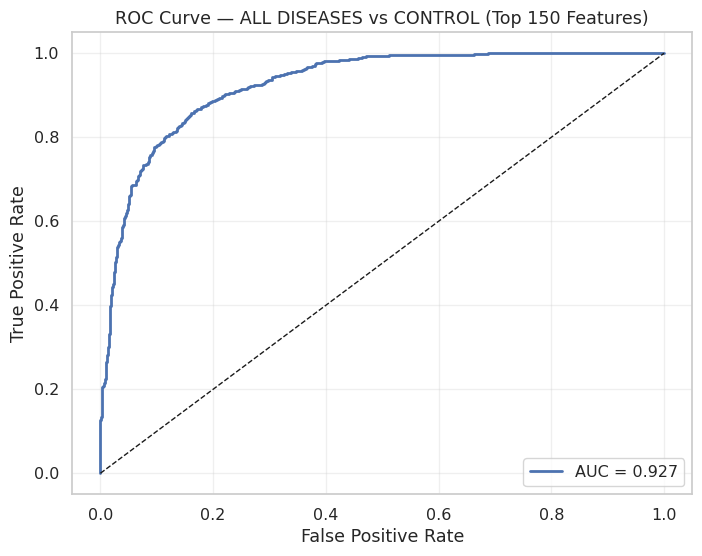

In [27]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# --- Select trained model and features ---
model = results['disease_full']['model']
X = results['disease_full']['X_train'].values
y = results['disease_full']['y_train']

# --- Predict probabilities ---
y_scores = model.predict_proba(X)[:, 1]

# --- Compute ROC curve ---
fpr, tpr, thresholds = roc_curve(y, y_scores)
roc_auc = auc(fpr, tpr)

# --- Plot ROC curve ---
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}", linewidth=2)
plt.plot([0,1], [0,1], 'k--', linewidth=1)

plt.title("ROC Curve — ALL DISEASES vs CONTROL (Top 150 Features)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

plt.show()


Confusion Matrix:
[[ 541  101]
 [ 177 1012]]


<Figure size 600x500 with 0 Axes>

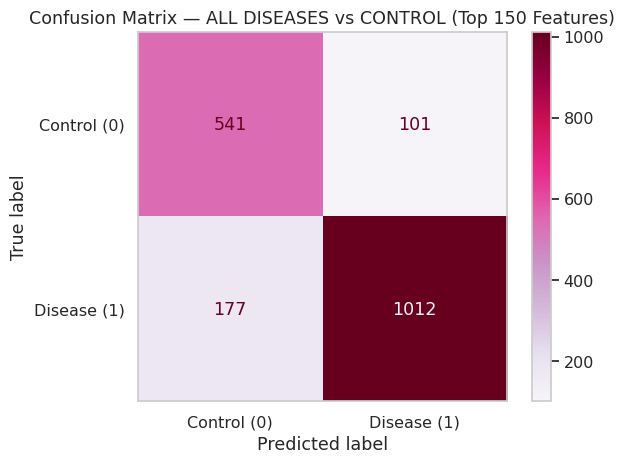

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# --- Predict class labels ---
y_pred = model.predict(X)

# --- Confusion Matrix ---
cm = confusion_matrix(y, y_pred)

# Print numerical matrix
print("Confusion Matrix:")
print(cm)

# --- Plot Confusion Matrix ---
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Control (0)", "Disease (1)"])

plt.figure(figsize=(6, 5))
disp.plot(cmap="PuRd", values_format="d")
plt.title("Confusion Matrix — ALL DISEASES vs CONTROL (Top 150 Features)")
plt.grid(False)
plt.show()


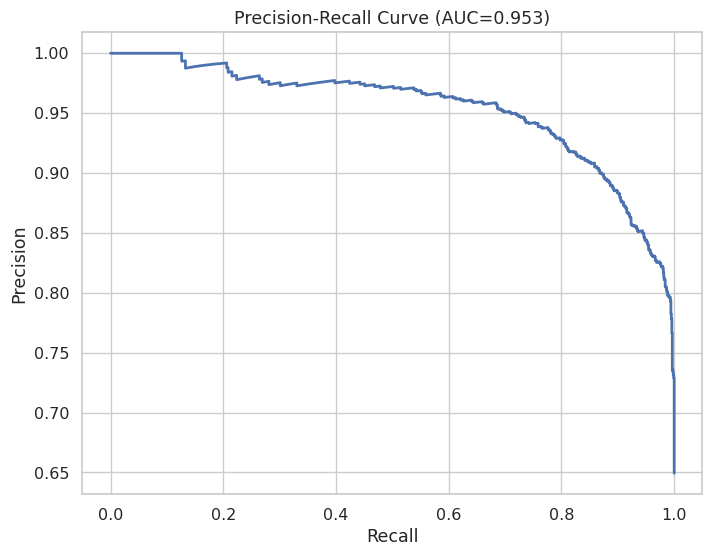

In [32]:
from sklearn.metrics import precision_recall_curve, auc

y_scores = model.predict_proba(X)[:,1]
precision, recall, thresholds = precision_recall_curve(y, y_scores)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall Curve (AUC={pr_auc:.3f})")
plt.grid(True)
plt.show()


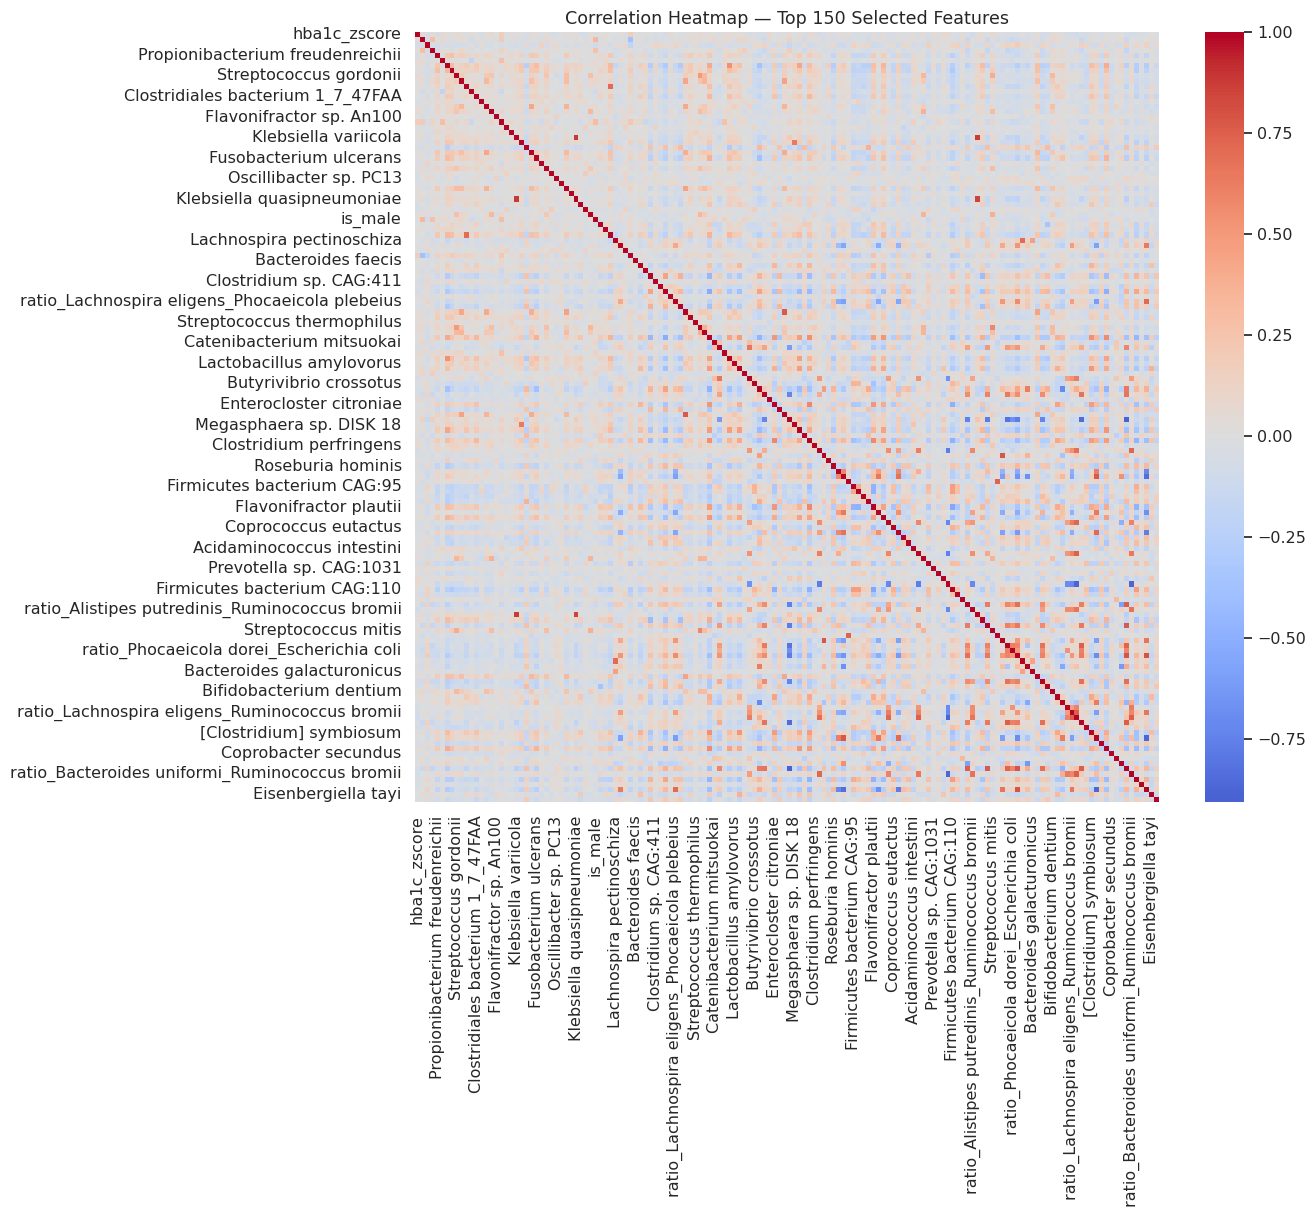

In [34]:
import seaborn as sns

top150 = results['disease_full']['feature_importance']['feature'].head(150)
corr = X_full[top150].corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap — Top 150 Selected Features")
plt.show()



TOP 20 FEATURES:
Streptococcus gordonii
Veillonella sp. T11011-6
Intestinibacter bartlettii
Ruminococcus callidus
Catenibacterium mitsuokai
Anaerobutyricum hallii
Klebsiella variicola
Blautia wexlerae
ratio_Lachnospira eligens_Akkermansia muciniph
Streptococcus thermophilus
Eubacterium sp. CAG:180
Bacteroides faecis
Propionibacterium freudenreichii
age_senior
Dialister invisus
Eubacterium sp. CAG:38
Lachnospira pectinoschiza
hsCRP_zscore
is_overweight
hba1c_zscore


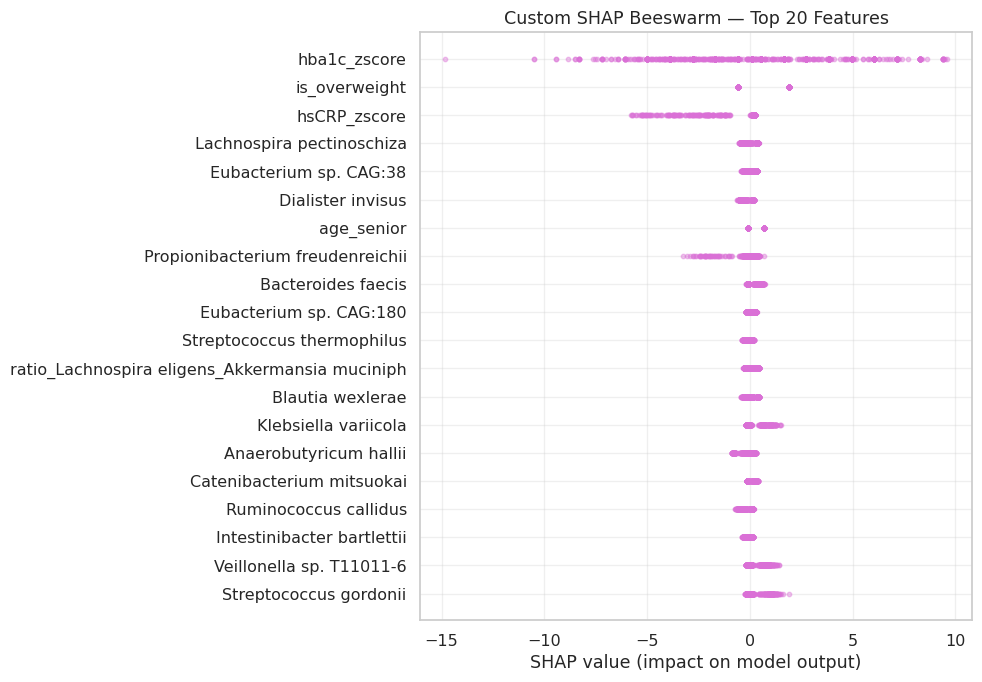

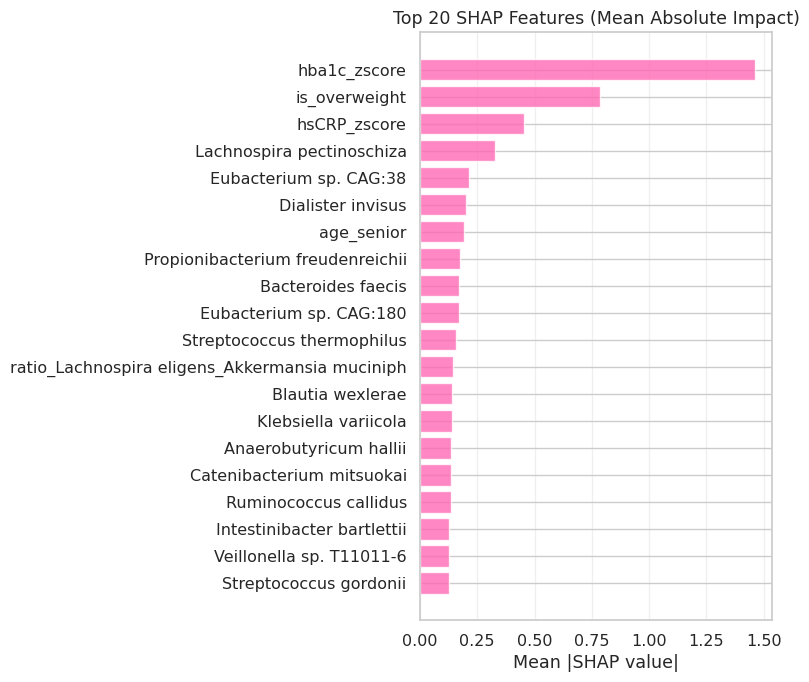

In [38]:
# ===========================================================
# FULL SHAP PIPELINE without SHAP's broken plotting functions
# ===========================================================
import shap
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 1. Load trained model + feature matrix
model = results['disease_full']['model']
X_train = results['disease_full']['X_train']   # Top 150 features

# 2. Background sample
background = X_train.sample(min(100, len(X_train)), random_state=2025)

# 3. SHAP explainer
explainer = shap.LinearExplainer(model, background)

# 4. Compute SHAP values
sv = explainer.shap_values(X_train)

# If multiclass, pick class 1
sv = np.array(sv)
if sv.ndim == 3:
    sv = sv[1]

# 5. Compute mean |SHAP|
mean_abs = np.abs(sv).mean(axis=0)

# 6. Select top 20 features
top20_idx = np.argsort(mean_abs)[-20:]
top20_features = X_train.columns[top20_idx]
top20_sv = sv[:, top20_idx]

print("\nTOP 20 FEATURES:")
for f in top20_features:
    print(f)

# ===========================================================
# CUSTOM BEESWARM (no shap.summary_plot)
# ===========================================================
plt.figure(figsize=(10, 7))

for i, feat_idx in enumerate(top20_idx):
    plt.scatter(
        sv[:, feat_idx],
        np.ones_like(sv[:, feat_idx]) * i,
        alpha=0.4,
        s=10,
        color="orchid"
    )

plt.yticks(range(20), top20_features)
plt.xlabel("SHAP value (impact on model output)")
plt.title("Custom SHAP Beeswarm — Top 20 Features")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ===========================================================
# CUSTOM BAR PLOT (no shap.summary_plot(bar))
# ===========================================================
sorted_idx = top20_idx[np.argsort(mean_abs[top20_idx])]
sorted_feats = X_train.columns[sorted_idx]
sorted_vals = mean_abs[sorted_idx]

plt.figure(figsize=(8, 7))
plt.barh(sorted_feats, sorted_vals, color="hotpink", alpha=0.8)
plt.xlabel("Mean |SHAP value|")
plt.title("Top 20 SHAP Features (Mean Absolute Impact)")
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


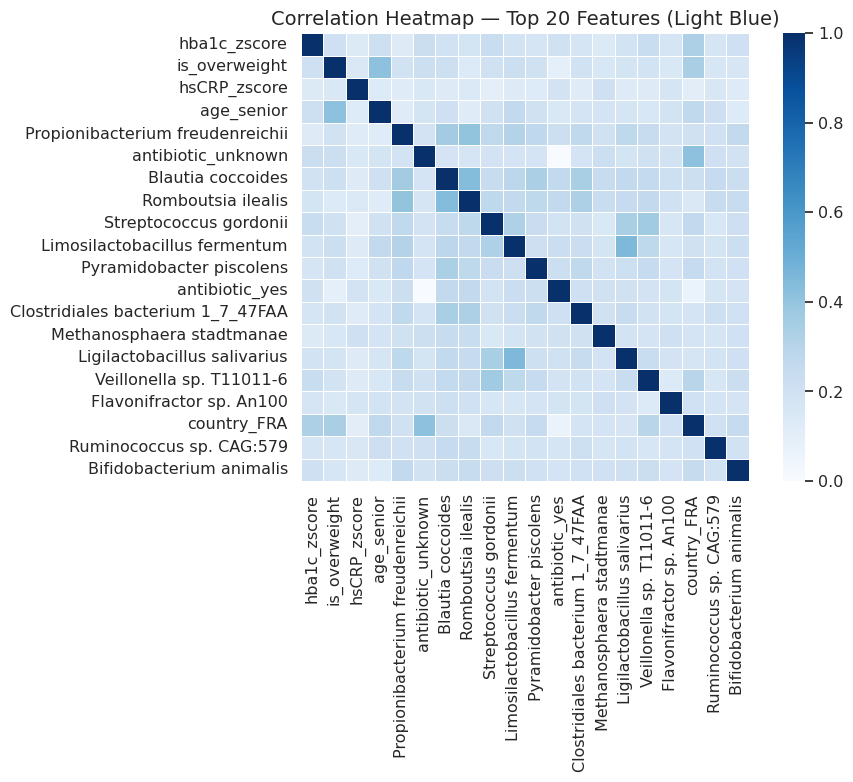

In [44]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Compute correlation for top 20 features
corr20 = X_top20.corr()

# Normalize to 0-1 so colors show clearly
corr_norm = (corr20 - corr20.min().min()) / (corr20.max().max() - corr20.min().min())

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_norm,
    cmap="Blues",
    square=True,
    linewidths=0.4,
    linecolor='white'
)
plt.title("Correlation Heatmap — Top 20 Features (Light Blue)", fontsize=14)
plt.tight_layout()
plt.show()




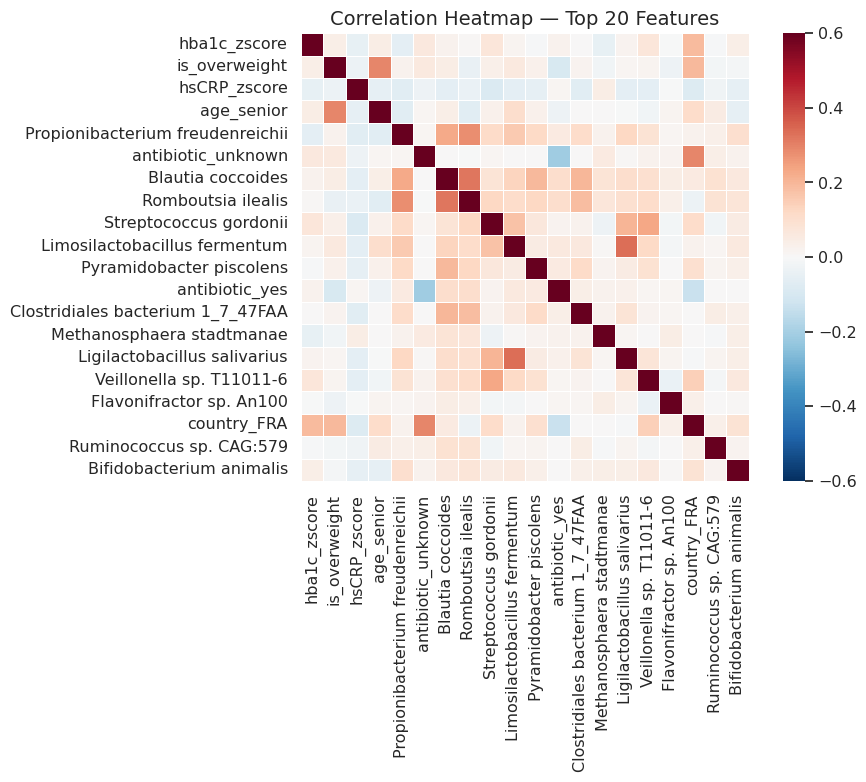

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix for the top 20 features
corr20 = X_top20.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr20,
    cmap='RdBu_r',    # ← change to 'RdBu_r' if you prefer
    annot=False,
    square=True,
    linewidths=0.4,
    linecolor='white',
    vmin=-0.6, vmax=0.6      # important: ensures full heatmap contrast
)
plt.title("Correlation Heatmap — Top 20 Features", fontsize=14)
plt.tight_layout()
plt.show()


“The correlation heatmap of the top 20 predictive features shows that clinical variables (HbA1c, BMI, hsCRP, age) are moderately correlated with each other, reflecting shared metabolic risk patterns.

Microbiome taxa, however, show generally weak inter-correlations, indicating that the selected microbes contribute largely independent predictive information to the model.

Antibiotic use indicators show mild correlations with specific taxa, consistent with known biological effects of antibiotics on gut microbiota.

Overall, the heatmap confirms that the selected features provide complementary rather than redundant information, supporting their usefulness in the predictive model.

Running fast SHAP using shap.Explainer...
SHAP values shape: (1831, 150)
Computed SHAP values for 1831 samples and 150 features

=== Creating SHAP Summary Plot ===


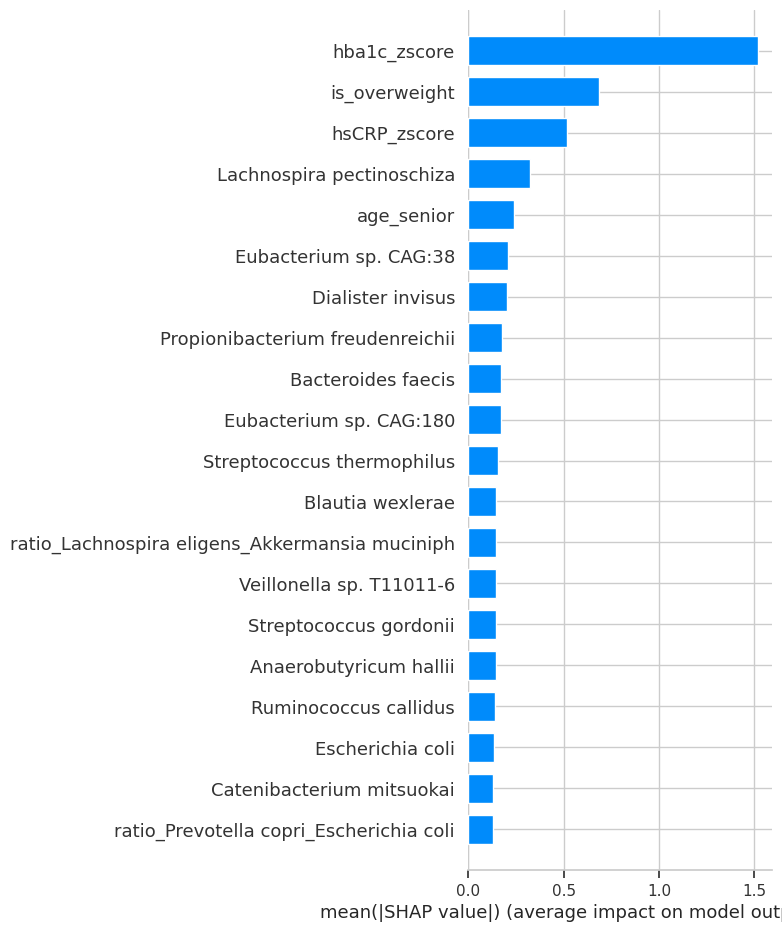


=== Creating Detailed SHAP Summary Plot ===


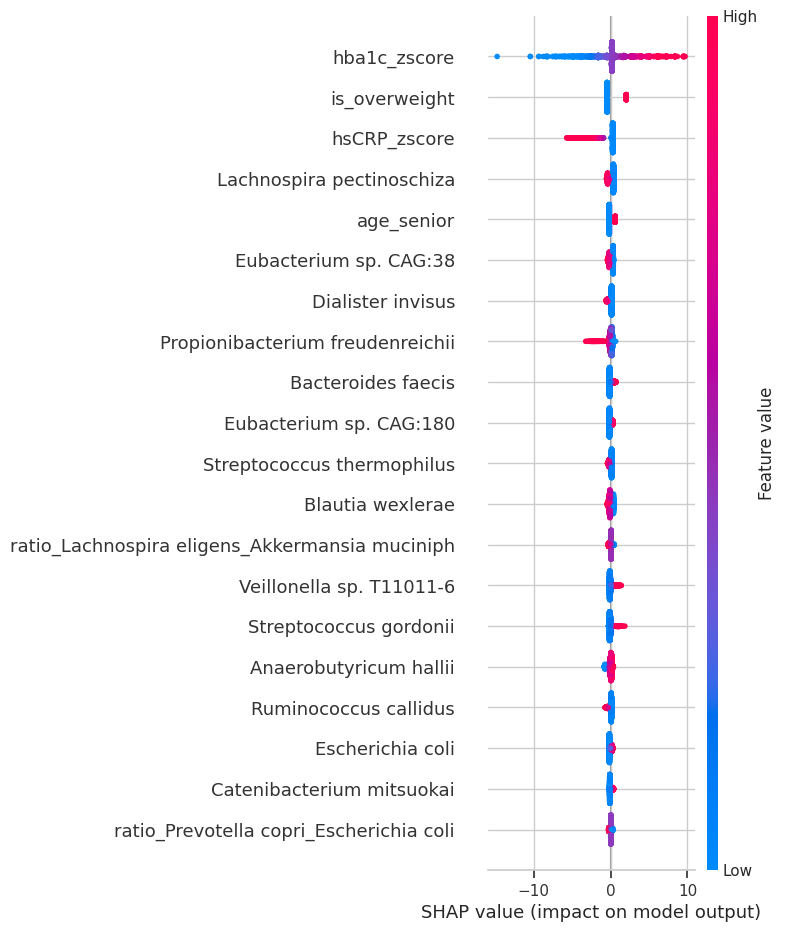


=== Waterfall Plot for Disease Sample 0 ===


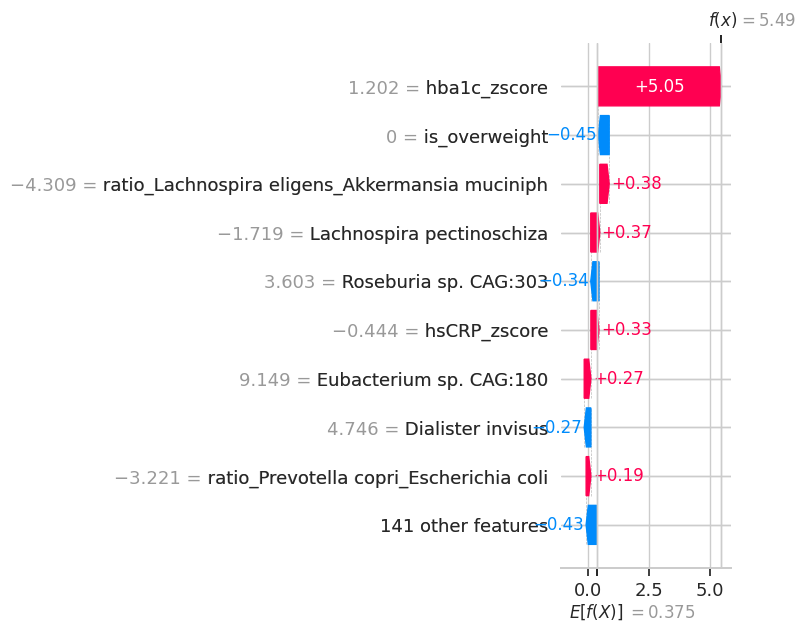


=== Waterfall Plot for Control Sample 3 ===


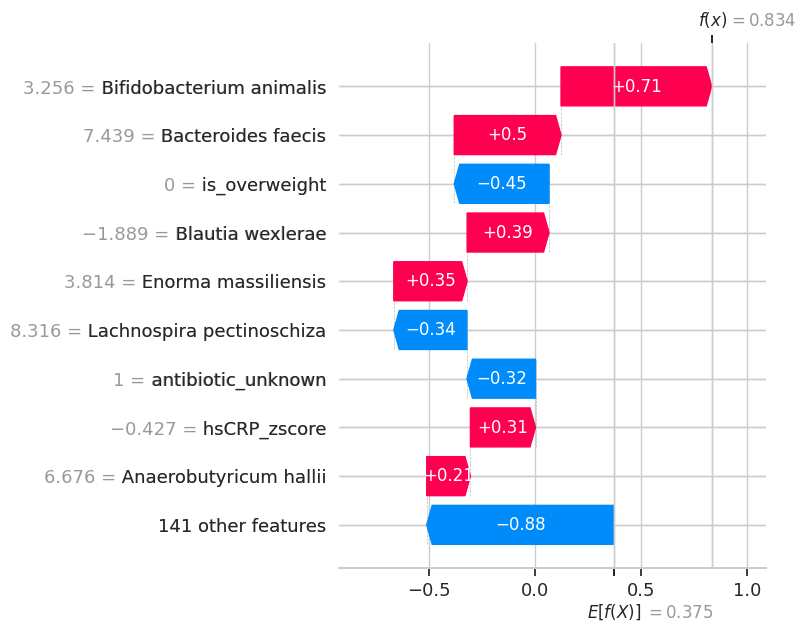


=== Creating Force Plot ===


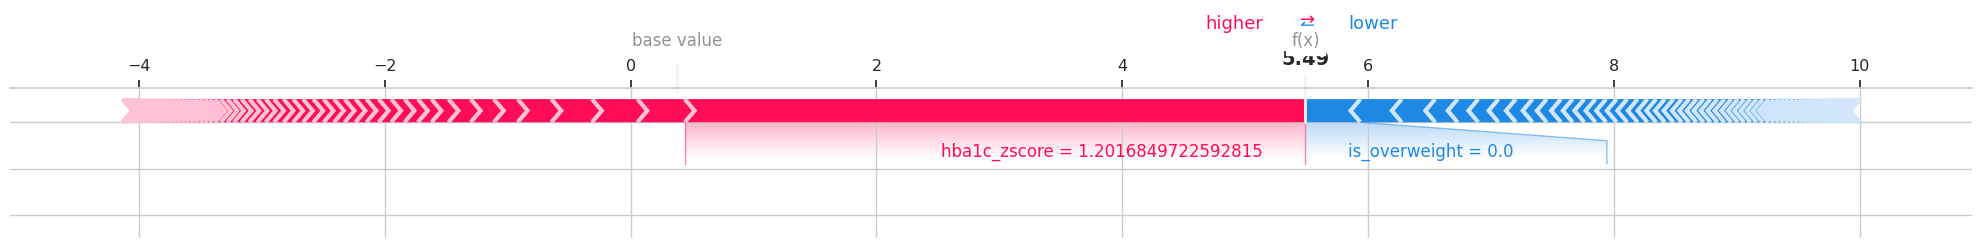


=== Dependence Plots for Top 3 Features ===

Dependence plot for: hba1c_zscore


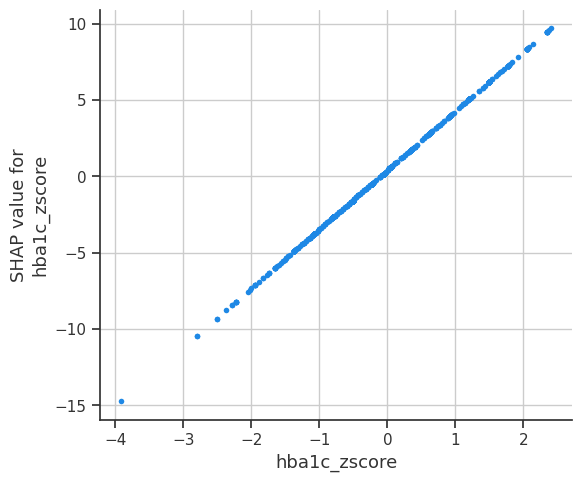


Dependence plot for: is_overweight


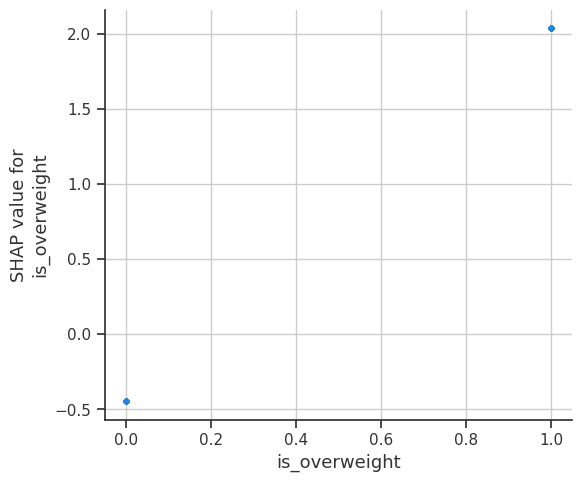


Dependence plot for: hsCRP_zscore


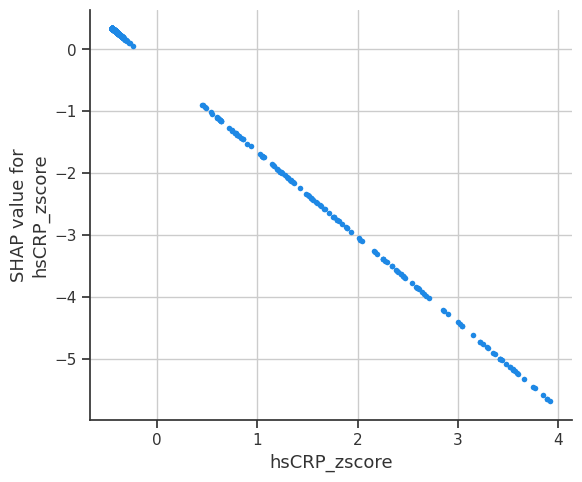


=== SHAP Value Statistics ===

Top 15 Features by Mean Absolute SHAP Value:
                                       feature  mean_abs_shap
                                  hba1c_zscore       1.517165
                                 is_overweight       0.683322
                                  hsCRP_zscore       0.519068
                     Lachnospira pectinoschiza       0.325294
                                    age_senior       0.239809
                        Eubacterium sp. CAG:38       0.206873
                             Dialister invisus       0.200868
              Propionibacterium freudenreichii       0.175952
                            Bacteroides faecis       0.173133
                       Eubacterium sp. CAG:180       0.170552
                    Streptococcus thermophilus       0.156371
                              Blautia wexlerae       0.146679
ratio_Lachnospira eligens_Akkermansia muciniph       0.145830
                      Veillonella sp. T11011-6       0.

In [58]:
import shap

print("Running fast SHAP using shap.Explainer...")

# Extract the trained model and data
model = results['disease_full']['model']
X_train = results['disease_full']['X_train']
y_train = results['disease_full']['y_train']

# Create SHAP explainer for logistic regression
explainer = shap.LinearExplainer(model, X_train)

# Calculate SHAP values for all training samples
shap_values = explainer.shap_values(X_train)

# For binary classification, shap_values might be a single array or tuple
# We need the values for the positive class (disease)
if isinstance(shap_values, list):
    shap_values = shap_values[1]  # Get positive class

print(f"SHAP values shape: {shap_values.shape}")
print(f"Computed SHAP values for {shap_values.shape[0]} samples and {shap_values.shape[1]} features")

# 1. Summary Plot - Shows feature importance and impact distribution
print("\n=== Creating SHAP Summary Plot ===")
shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=20, show=False)
import matplotlib.pyplot as plt
plt.tight_layout()
plt.show()

# 2. Detailed Summary Plot - Shows feature values and their SHAP impacts
print("\n=== Creating Detailed SHAP Summary Plot ===")
shap.summary_plot(shap_values, X_train, max_display=20, show=False)
plt.tight_layout()
plt.show()

# 3. Waterfall plot for a disease sample
disease_indices = np.where(y_train == 1)[0]
sample_idx = disease_indices[0]  # First disease sample

print(f"\n=== Waterfall Plot for Disease Sample {sample_idx} ===")
shap.plots.waterfall(shap.Explanation(
    values=shap_values[sample_idx],
    base_values=explainer.expected_value,
    data=X_train.iloc[sample_idx].values,
    feature_names=X_train.columns.tolist()
), show=False)
plt.tight_layout()
plt.show()

# 4. Waterfall plot for a control sample
control_indices = np.where(y_train == 0)[0]
sample_idx_control = control_indices[0]  # First control sample

print(f"\n=== Waterfall Plot for Control Sample {sample_idx_control} ===")
shap.plots.waterfall(shap.Explanation(
    values=shap_values[sample_idx_control],
    base_values=explainer.expected_value,
    data=X_train.iloc[sample_idx_control].values,
    feature_names=X_train.columns.tolist()
), show=False)
plt.tight_layout()
plt.show()

# 5. Force plot for interactive visualization
print("\n=== Creating Force Plot ===")
shap.force_plot(
    explainer.expected_value,
    shap_values[sample_idx],
    X_train.iloc[sample_idx],
    matplotlib=True,
    show=False
)
plt.tight_layout()
plt.show()

# 6. Dependence plots for top features
top_features = results['disease_full']['feature_importance'].head(3)['feature'].tolist()

print(f"\n=== Dependence Plots for Top 3 Features ===")
for feature in top_features:
    print(f"\nDependence plot for: {feature}")
    shap.dependence_plot(
        feature,
        shap_values,
        X_train,
        interaction_index=None,
        show=False
    )
    plt.tight_layout()
    plt.show()

# 7. Summary statistics
print("\n=== SHAP Value Statistics ===")
mean_abs_shap = np.abs(shap_values).mean(axis=0)
shap_importance = pd.DataFrame({
    'feature': X_train.columns,
    'mean_abs_shap': mean_abs_shap
}).sort_values('mean_abs_shap', ascending=False)

print("\nTop 15 Features by Mean Absolute SHAP Value:")
print(shap_importance.head(15).to_string(index=False))

# 8. Compare SHAP importance with coefficient magnitude
comparison = results['disease_full']['feature_importance'].merge(
    shap_importance,
    on='feature',
    how='inner'
)

print("\n=== Comparison: Coefficient vs SHAP Importance (Top 10) ===")
print(comparison[['feature', 'coefficient', 'mean_abs_shap']].head(10).to_string(index=False))